# Installation of Required Libraries

##### I will need some libraries for EDF reading, signal processing and machine learning.

In [65]:
 pip install mne

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [67]:
pip install pyedflib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [69]:
pip install numpy pandas scikit-learn matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


### 1. Import Libraries

In [72]:
import os
import mne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.signal import welch
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay 

### 2. Loading of EDF and Hypnogram files

In [75]:
path = r"C:\Users\Admin\PycharmProjects\SVM-RF-with-Sleep-Database"
data_dir = os.path.join(path, "Data001")
files = os.listdir(data_dir)

print("Files in folder:", files)

# Assign the first and second items
edf_file = files[0]
annot_file = files[1]

print("First file:", edf_file)
print("Second file:", annot_file)
#file_path = os.path.join(path, "Data001", "SC4001E0-PSG.edf")

Files in folder: ['SC4001E0-PSG.edf', 'SC4001EC-Hypnogram.edf']
First file: SC4001E0-PSG.edf
Second file: SC4001EC-Hypnogram.edf


In [77]:
path_edf = os.path.join(data_dir, edf_file)
path_annot = os.path.join(data_dir, annot_file)
data = mne.io.read_raw_edf(path_edf, preload=True)
annots = mne.read_annotations(path_annot)
data.set_annotations(annots)

Extracting EDF parameters from C:\Users\Admin\PycharmProjects\SVM-RF-with-Sleep-Database\Data001\SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...


C:\Users\Admin\AppData\Local\Temp\ipykernel_21340\2229384140.py:3: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  data = mne.io.read_raw_edf(path_edf, preload=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_21340\2229384140.py:3: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  data = mne.io.read_raw_edf(path_edf, preload=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_21340\2229384140.py:3: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  data = mne.io.read_raw_edf(path_edf, preload=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_21340\2229384140.py:5: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  data.set_annotations(annots)


<RawEDF | SC4001E0-PSG.edf, 7 x 7950000 (79500.0 s), ~424.6 MiB, data loaded>

### 3. Resampling

In [80]:
data.resample(50)

<RawEDF | SC4001E0-PSG.edf, 7 x 3975000 (79500.0 s), ~212.3 MiB, data loaded>

### 4. Extraction of Epochs

In [83]:
mapping = {
    "Sleep stage W": 0,   # Wake
    "Sleep stage 1": 1,
    "Sleep stage 2": 2,
    "Sleep stage 3": 3,
    "Sleep stage 4": 3,  # merge stage3/stage4
    "Sleep stage R": 4
}

events, event_id = mne.events_from_annotations(data, event_id=mapping)

epochs = mne.Epochs(
    data,
    events,
    event_id=None,
    tmin=0,
    tmax=30,
    baseline=None,
    detrend=1,
    preload=True
)

labels = epochs.events[:, -1]  # numeric stage labels
print(labels)

#unique, counts = np.unique(labels, return_counts=True)
#stage_counts = dict(zip(unique, counts))
#print("Counts per stage (integer labels):", stage_counts)

#id_to_stage = {0: "W", 1: "N1", 2: "N2", 3: "N3", 4: "REM"}
#stage_counts_named = {id_to_stage[k]: v for k, v in stage_counts.items()}
#print("Counts per stage (names):", stage_counts_named)

#print("Total (items): ", len(labels))

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
153 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 153 events and 1501 original time points ...
0 bad epochs dropped
[0 1 2 3 2 3 3 3 3 3 3 3 3 0 3 2 3 3 3 3 2 3 2 3 1 2 3 2 3 2 3 3 3 2 3 3 3
 3 1 3 2 3 2 3 4 1 2 3 1 2 1 2 3 2 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3
 1 2 1 2 1 2 1 2 4 2 1 0 1 2 1 2 1 2 3 2 3 2 3 2 3 3 3 2 3 2 3 3 3 3 3 3 2
 3 3 2 4 1 4 0 1 0 1 0 1 2 0 1 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 1 4 0 1 4 0 1
 0 1 0 1 0]


### 5. Extracts the numeric stage codes for each epoch.

In [86]:
# Converts numeric stage codes into binary labels (0/1).
# 0 = Awake (W)
# 1 = Asleep (N1, N2, N3, REM)

stage_map = {
    0: 0,  # Wake -> 0
    1: 1,  # N1 -> Sleep
    2: 1,  # N2 -> Sleep
    3: 1,  # N3 -> Sleep
    4: 1   # REM -> Sleep
}

# y = target labels for classification.
y = np.array([stage_map[item] for item in labels])

print(np.unique(y, return_counts=True))


(array([0, 1]), array([ 12, 141], dtype=int64))


### 6. Feature Extraction (with one channel (e.g. EEG Fpz-Cz))

In [89]:
def extract_features(epoch_data, sfreq):
    # Extracts spectral band powers from one epoch
    f, psd = welch(epoch_data, sfreq, nperseg=sfreq*2)
    bands = {
        "delta": (0.5, 4),
        "theta": (4, 8),
        "alpha": (8, 12),
        "beta": (12, 30)
    }
    feats = []
    for (low, high) in bands.values():
        idx = np.logical_and(f >= low, f <= high)
        feats.append(np.mean(psd[idx]))
        
    # Add time-domain features
    feats.append(np.mean(epoch_data))
    feats.append(np.std(epoch_data))
    return np.array(feats)

X = []
for ep in epochs.get_data():    # shape (n_epochs, n_channels, n_times)
    ep_data = ep[0]             # take only first EEG channel
    feats = extract_features(ep_data, epochs.info['sfreq'])
    X.append(feats)

X = np.vstack(X)
#print(epochs.info['ch_names'][0])
#print(X)

### 7. Splitting of Train and Test (with one channel)

In [92]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

### 8. Support Vector Machines (with one channel)

In [95]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm = SVC(kernel='rbf', C=1, gamma='scale')
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)


### 9. Random Forest (with one channel)

In [98]:
rf = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


### 10. Evaluation (with one EEG channel and few features)

In [105]:
print("=== SVM Results ===")
print(classification_report(y_test, y_pred_svm, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred_svm))

print("\n=== Random Forest Results ===")
print(classification_report(y_test, y_pred_rf, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))


=== SVM Results ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.94      1.00      0.97        29

    accuracy                           0.94        31
   macro avg       0.47      0.50      0.48        31
weighted avg       0.88      0.94      0.90        31

Accuracy: 0.9354838709677419

=== Random Forest Results ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.93      0.97      0.95        29

    accuracy                           0.90        31
   macro avg       0.47      0.48      0.47        31
weighted avg       0.87      0.90      0.89        31

Accuracy: 0.9032258064516129


# =============== k-fold Cross-validation =====================

### 1. Application of k-fold Cross-validation (Random Forest)

In [109]:
# Flatten EEG data per epoch for simple classifier (n_epochs, features)
X_reshaped = X.reshape(X.shape[0], -1)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)

scores = []

for train_index, test_index in kf.split(X_reshaped, y):
    X_train, X_test = X_reshaped[train_index], X_reshaped[test_index]
    y_train, y_test = y[train_index], y[test_index]

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    scores.append(acc)

print("Cross-validation accuracies:", scores)
print("Mean CV accuracy:", np.mean(scores))

Cross-validation accuracies: [0.9354838709677419, 0.8709677419354839, 0.967741935483871, 0.8666666666666667, 0.9666666666666667]
Mean CV accuracy: 0.921505376344086


# =========== Morlet Wavelets and Confusion Matrix =============

### 2. Compute Features Using Morlet Wavelets

In [113]:
# Define frequencies of interest (e.g., typical EEG bands)
freqs = np.arange(1, 25, 1)  # 1 Hz to 30 Hz
n_cycles = freqs / 2.0        # different n_cycles per frequency

# Compute time-frequency representation using complex Morlet wavelets
power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles,
                                      use_fft=True, return_itc=False,
                                      decim=3, average=False)

# power.data shape: (n_epochs, n_channels, n_freqs, n_times)
# Flatten to features for classifier
X_features = power.data.reshape(power.data.shape[0], -1)


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


### 3. Train Classifier Using Morlet Wavelets (Random Forest)

In [118]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

y_true_all = []
y_pred_all = []
fold_accuracies = []

for train_idx, test_idx in kf.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)
    fold_accuracies.append(accuracy_score(y_test, y_pred))

### 4. Compute Confusion Matrix Using Morlet Wavelets

Confusion matrix:
 [[  3   9]
 [  3 138]]


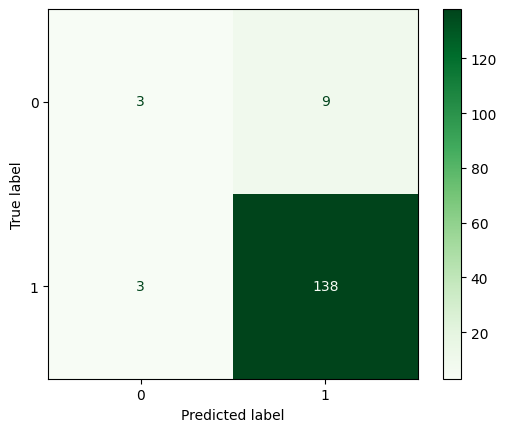

In [121]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true_all, y_pred_all)
#cm= confusion_matrix(y_true_all, y_pred_all, normalize='true')
print("Confusion matrix:\n", cm)

# Optional: plot it
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=np.unique(y))
disp.plot(cmap='Greens')


# ========= Complex Morlet Wavelets and Confusion Matrix ==========

### 5. Compute Features Using Complex Morlet Wavelets

In [125]:
power = mne.time_frequency.tfr_morlet(
    epochs,
    freqs=freqs,
    n_cycles=n_cycles,
    return_itc=False,     
    average=False,        
    decim=3,              
    n_jobs=-1             
)

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    5.9s remaining:   14.9s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    6.0s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    6.2s finished


### 6. Extract Features from Complex Morlet Output

In [128]:
# Average power over time → (n_epochs, n_channels, n_freqs)
X_power = power.data.mean(axis=-1)

# Flatten into feature vectors → (n_epochs, features)
X_features = X_power.reshape(X_power.shape[0], -1)

# Define bands
bands = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
}

X_band = []
for name, (fmin, fmax) in bands.items():
    fmask = (freqs >= fmin) & (freqs < fmax)
    band_power = power.data[:, :, fmask, :].mean(axis=(2, 3))  # mean over freqs + time
    X_band.append(band_power)

# Concatenate features from all bands → (n_epochs, n_channels * n_bands)
X_band = np.concatenate(X_band, axis=1)   # Now X_band is much smaller (compact features)

# Phase Information
#phase_data = np.angle(power.data)  # same shape as power.data

### 7. Train Classifier Using Complex Morlet Wavelets (Random Forest)

In [131]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

y_true_all = []
y_pred_all = []
fold_accuracies = []

for train_idx, test_idx in kf.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)
    fold_accuracies.append(accuracy_score(y_test, y_pred))

### 8. Compute Confusion Matrix Using Complex Morlet Wavelets

Normalized confusion matrix:
 [[  3   9]
 [  3 138]]


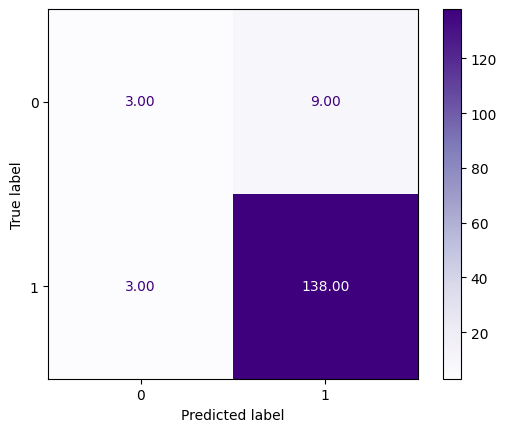

In [134]:
cm = confusion_matrix(y_true_all, y_pred_all, labels=np.unique(y))
#cm = confusion_matrix(y_true_all, y_pred_all, labels=np.unique(y), normalize='true')

#print("Confusion matrix:\n", cm)
print("Normalized confusion matrix:\n", cm)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=np.unique(y))
disp.plot(cmap='Purples', values_format=".2f")

# =========== Boxplots and Scatterplots =============

### 9.Applying Boxplots

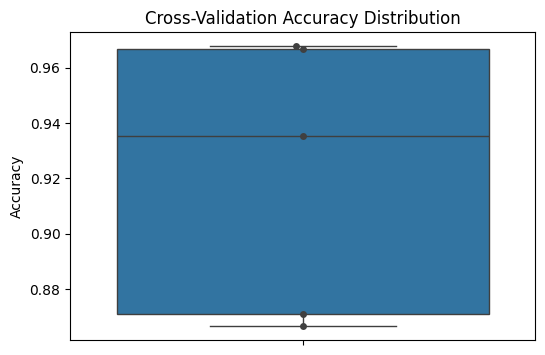

In [138]:
# -----------------------------
# Boxplot of CV Accuracies
# -----------------------------
plt.figure(figsize=(6, 4))
sns.boxplot(data=fold_accuracies)
sns.swarmplot(data=fold_accuracies, color=".25")  # show individual points
plt.ylabel("Accuracy")
plt.title("Cross-Validation Accuracy Distribution")
plt.show()


### 10. Applying Scatterplots

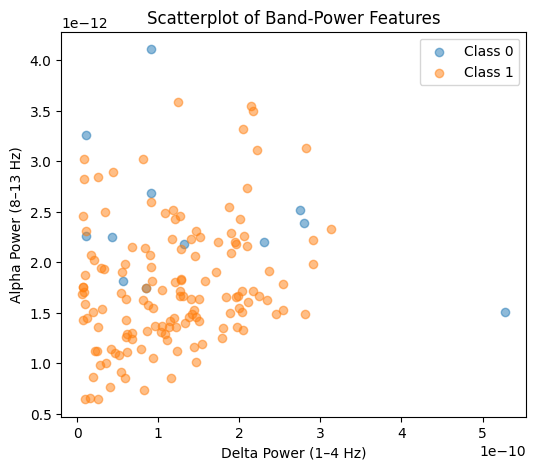

In [141]:
# -----------------------------
# Scatterplot of Features
# -----------------------------
# Let's take two band-power features for visualization (e.g., delta vs alpha on channel 0)
delta_idx = 0
alpha_idx = 2

plt.figure(figsize=(6, 5))
for label in np.unique(y):
    mask = np.array(y) == label
    plt.scatter(X[mask, delta_idx], X[mask, alpha_idx], alpha=0.5, label=f"Class {label}")

plt.xlabel("Delta Power (1–4 Hz)")
plt.ylabel("Alpha Power (8–13 Hz)")
plt.title("Scatterplot of Band-Power Features")
plt.legend()
plt.show()

# =========== Spiking Neural Networks (SNN) ===========

### 11. Applying SNN

In [145]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cpu
Note: you may need to restart the kernel to use updated packages.


In [146]:
pip install snntorch

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Epoch 1/10, Loss: 1.2260
Epoch 2/10, Loss: 1.1793
Epoch 3/10, Loss: 1.1257
Epoch 4/10, Loss: 1.0727
Epoch 5/10, Loss: 1.0281
Epoch 6/10, Loss: 0.9726
Epoch 7/10, Loss: 0.9213
Epoch 8/10, Loss: 0.8912
Epoch 9/10, Loss: 0.8399
Epoch 10/10, Loss: 0.7911


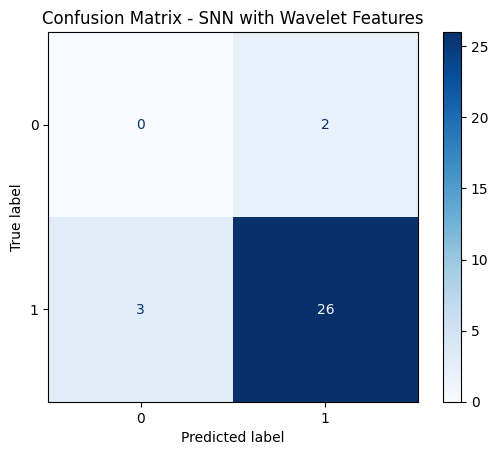

In [149]:
import torch
import snntorch as snn
from snntorch import surrogate
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# --------------------------
# 1. Prepare features
# --------------------------
X = torch.tensor(X, dtype=torch.float32)   # wavelet features
y = torch.tensor(y, dtype=torch.long)      # labels

# Normalize features
scaler = StandardScaler()
X = torch.tensor(scaler.fit_transform(X), dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# --------------------------------------------------
# 2. Encode features into spike trains (rate coding)
# --------------------------------------------------
def rate_encode(features, time_steps=50):
    # features in [0,1] after scaling
    rand = torch.rand((time_steps, *features.shape))
    return (rand < features.unsqueeze(0)).float()

time_steps = 50
X_train_spike = rate_encode(X_train, time_steps)
X_test_spike = rate_encode(X_test, time_steps)

# --------------------------
# 3. Build a simple SNN
# --------------------------
num_inputs = X.shape[1]
num_hidden = 64
num_outputs = len(torch.unique(y))

beta = 0.9  # membrane leak

class SNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        spk2_rec = []
        for step in range(x.size(0)):
            cur1 = self.fc1(x[step])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)

        return torch.stack(spk2_rec)

net = SNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

# --------------------------
# 4. Train the SNN
# --------------------------
num_epochs = 10
for epoch in range(num_epochs):
    net.train()
    optimizer.zero_grad()
    spk_out = net(X_train_spike)
    out_sum = spk_out.sum(0)                # sum spikes over time
    loss = criterion(out_sum, y_train)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

# --------------------------
# 5. Evaluate
# --------------------------
net.eval()
with torch.no_grad():
    spk_out = net(X_test_spike)
    out_sum = spk_out.sum(0)
    y_pred = torch.argmax(out_sum, dim=1)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - SNN with Wavelet Features")
plt.show()


# ======= Extended SNN Evaluation with Boxplots & Scatterplots =====

# ============= Working with multi-channel ==============

### 11. Feature Extraction (with Multi-channel)

In [63]:
def hjorth_parameters(x):
    activity = np.var(x)
    diff1 = np.diff(x)
    mobility = np.sqrt(np.var(diff1)/activity)
    diff2 = np.diff(diff1)
    complexity = np.sqrt(np.var(diff2)/np.var(diff1)) / mobility
    return activity, mobility, complexity

def spectral_entropy(psd):
    psd_norm = psd / np.sum(psd)
    return -np.sum(psd_norm * np.log2(psd_norm + 1e-12))

def multi_extract_features(epoch_data, sfreq):
    feats = []
    for ch in range(epoch_data.shape[0]):  # Loop over channels
        data = epoch_data[ch]
        
        # Frequency features
        f, psd = welch(data, sfreq, nperseg=sfreq*2)
        bands = {"delta":(0.5,4), "theta":(4,8), "alpha":(8,12), "beta":(12,30)}
        band_powers = []
        for (low, high) in bands.values():
            idx = np.logical_and(f >= low, f <= high)
            power = np.mean(psd[idx])
            feats.append(power)
            band_powers.append(power)
        
        # Band ratios
        feats.append(band_powers[1]/band_powers[2])  # theta/alpha
        feats.append(band_powers[0]/band_powers[1])  # delta/theta
        
        # Spectral entropy
        feats.append(spectral_entropy(psd))
        
        # Time-domain features
        feats.append(np.mean(data))
        feats.append(np.std(data))
        feats.append(skew(data))
        feats.append(kurtosis(data))
        
        # Hjorth parameters
        activity, mobility, complexity = hjorth_parameters(data)
        feats.extend([activity, mobility, complexity])
        
    return np.array(feats)

### 12. Compute features for all epochs (with multi-channel)

In [66]:
X = []
for ep in epochs.get_data():  # ep shape = (n_channels, n_times)
    feats = multi_extract_features(ep, epochs.info['sfreq'])
    X.append(feats)
X = np.vstack(X)

### 13. Splitting of Train and Test (with multi-channel)

In [68]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

### 14. Support Vector Machines (with multi-channel)

In [72]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm = SVC(kernel='rbf', C=1, gamma='scale')
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)

### 15. Random Forest (with multi-channel)

In [75]:
rf = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

### 16. Evaluation (with multi-chanenel)

In [78]:
print("=== SVM Results ===")
print(classification_report(y_test, y_pred_svm, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred_svm))

print("\n=== Random Forest Results ===")
print(classification_report(y_test, y_pred_rf, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

=== SVM Results ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.94      1.00      0.97        29

    accuracy                           0.94        31
   macro avg       0.47      0.50      0.48        31
weighted avg       0.88      0.94      0.90        31

Accuracy: 0.9354838709677419

=== Random Forest Results ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00        29

    accuracy                           1.00        31
   macro avg       1.00      1.00      1.00        31
weighted avg       1.00      1.00      1.00        31

Accuracy: 1.0


# ========= k-fold Cross-validation (with multi-channel) ==========